### Goal
Analyze the input data of the model and define which subset of genes we will focus on. <br/>
Since some genes are harder to predict we will start will a small subset of the genes. <br/>
Preferably we search for genes which are expressed in the tissues and have a high variance across the tissues.

### TODO
1. Recheck the computation of the log ratios values
2. Define expressed genes in both blood and muscle
3. Correlation between blood and other tissue
4. Define variable genes in both blood and muscle
5. Filter genes for which the correlation 

### Conclusions
1. The computation seems to be correct. The expression variation of the genes across individuals do show a very small variation (std, var) = (5.146708852205819e-08, 2.09347686859362)across all genes and tissues. We need to be able to capture small variation. We do also observe data skewness, i.e. std and mean correlate for a set of genes.
2. Genes with a log2(TPM) > 0 in both tissues are considered expressed (in total ~ 8000 genes in Blood and Muscle).  
3. - The log ratios does not correlate from one tissue to the next (corr_coef < 0.1). By centering using the mean expression within the tissue, a non-linear component is introduced in the data. One can suggest working with the log2TPMs for building the model and afterwards subtract the mean expression.
 - For expressed genes we do observe small changes with respect to the mean and there is no clear correlation between input/target tissue.
4. - For cutoff > 1, 7641 genes are considered variable
 - Genes which are variable and expressed in both muscle and blood can be found here: `/s/project/rep/processed/gtex/input_data/genes_subset/candidate_genes.txt/`
 - For this set of genes we do observe for log2TPM a correlation of 0.7, while the centered data shows a correlation of 0.01
5. By computing the spearmanr correlation per gene (using the logratios), we do observe that the correlation for the most of the genes is very low. Keep only genes for which the correlation of the change relative to mean, between blood and muscle is > 0.15 (~4000 genes)


## 1. Recheck the computation of the log ratios values

In [1]:
from joblib import dump, load
import numpy as np
import pandas as pd

from rep import models_coord_descent as m
from rep import constants as cst
from rep import linear_regression as lr
from rep import preprocessing_new as prep

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

features_file = "/s/project/rep/processed/gtex/recount/recount_gtex_norm_tpm.h5ad"
gtex = prep.RepAnnData.read_h5ad(features_file)


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


(array([1.254e+04, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 5.000e+00, 8.000e+00, 6.000e+00, 1.100e+01,
        1.400e+01, 1.800e+01, 1.000e+01, 2.500e+01, 3.400e+01, 3.800e+01,
        4.600e+01, 7.200e+01, 9.300e+01, 1.310e+02, 1.910e+02, 2.260e+02,
        3.260e+02, 3.670e+02, 4.600e+02, 5.950e+02, 6.320e+02, 7.460e+02,
        8.830e+02, 9.690e+02, 1.088e+03, 1.268e+03, 1.335e+03, 1.501e+03,
        1.545e+03, 1.593e+03, 1.777e+03, 1.875e+03, 2.014e+03, 2.089e+03,
        2.211e+03, 2.324e+03, 2.378e+03, 2.550e+03, 2.764e+03, 2.930e+03,
        3.154e+03, 3.273e+03, 3.483e+03, 3.800e+03, 4.164e+03, 4.469e+03,
        5.111e+03, 5.450e+03, 6.047e+03, 6.636e+03, 7.219e+03, 7.765e+03,
        8.332e+03, 8.768e+03, 8.903e+03, 8.973e+03, 8.667e+03, 8.229e+03,
        7.378e+03, 6.327e+03, 5.257e+03, 4.488e+03, 3.412e+03, 2.559e+03,
        1.949e+03, 1.491e+03, 1.054e+03, 7.980e+02, 5.910e+02, 4.590e+02,
        3.370e+02, 2.790e+02, 1.980e+0

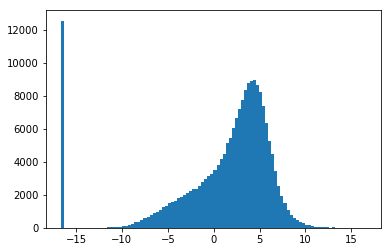

In [2]:
plt.hist(np.log2(gtex.X[:10, :].flatten() + 1e-5), bins=100)

In [3]:
log_gtex = np.log2(np.array(gtex.X)+ 1e-5)
gtex_log_obj = prep.RepAnnData(X=log_gtex, samples_obs = gtex.samples, genes_var = gtex.genes) 
gtex_log_obj.save(outname="/s/project/rep/processed/gtex/recount/recount_gtex_norm_log_tpm.h5ad")

'/s/project/rep/processed/gtex/recount/recount_gtex_norm_log_tpm.h5ad'

In [4]:
all_tissues = gtex.samples['Tissue'].drop_duplicates().tolist()

genes = gtex.genes['gene_id'].tolist()
df_mean_expression = pd.DataFrame(columns=['Tissue']+genes)
df_std_expression = pd.DataFrame(columns=['Tissue']+genes)

for t in all_tissues:
    tmp = np.array(gtex_log_obj[gtex_log_obj.samples['Tissue'] == t].X)
    avg_per_gene = np.mean(tmp, axis = 0)
    std_per_gens = np.std(tmp, axis = 0)
    
    dict = {}
    dict['Tissue'] = t
    
    dict_std = {}
    dict_std['Tissue'] = t
    
    
    for i, g in enumerate(avg_per_gene): 
        dict[genes[i]] = g
        dict_std[genes[i]] = std_per_gens[i]
        
    df_mean_expression = df_mean_expression.append(dict, ignore_index = True)
    df_std_expression = df_std_expression.append(dict_std, ignore_index = True)

In [5]:
df_mean_expression[:10]

,Tissue,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,...,ENSG00000283619.1,ENSG00000283620.1,ENSG00000283623.1,ENSG00000283632.1,ENSG00000283644.1,ENSG00000283652.1,ENSG00000283654.1,ENSG00000283663.1,ENSG00000283683.1,ENSG00000283697.1
0,Lung,3.934411,-7.061137,5.164188,3.450565,2.040772,7.090200,6.284167,5.164246,3.850434,...,-12.922646,2.520906,4.428079,1.743891,-11.595976,2.051348,-2.649020,0.568314,-2.481456,0.670648
1,Brain - Cerebellar Hemisphere,1.245691,-9.508263,4.953715,3.640158,2.620209,1.466909,1.596887,2.924474,3.539205,...,0.309788,3.624964,3.854307,-4.342666,-13.773940,-3.004126,-2.335590,-9.331906,-3.010122,-0.166834
2,Heart - Left Ventricle,1.587957,-4.495821,4.296491,1.610316,0.093737,1.991359,3.366908,3.674290,2.347455,...,-13.606180,1.300155,2.551942,-1.035752,-12.786122,-2.710737,-4.106084,-4.538107,-3.485749,-0.547461
3,Skin - Sun Exposed (Lower leg),3.621644,1.367617,5.151826,3.817161,2.268977,2.680825,6.110232,3.886063,3.914955,...,-10.125227,2.709556,3.572181,0.454363,-11.914911,-1.014251,-4.059111,2.453930,-2.394210,0.098325
4,Brain - Amygdala,3.341791,-3.560966,3.873657,1.971747,0.732639,2.239481,2.619497,3.205035,3.715291,...,-1.315685,1.889023,2.980900,-4.292107,-15.276862,-1.373850,-2.692829,-5.195673,-6.314097,-1.135062
5,Adipose - Subcutaneous,5.191254,4.257592,5.289719,3.622812,2.276214,4.881677,7.032775,5.157929,4.405013,...,-13.556317,2.222874,4.546435,1.666342,-11.739365,0.214358,-2.937885,-3.148119,0.305071,0.394766
6,Brain - Cortex,2.664114,-2.701482,4.412127,2.426074,1.075619,2.573719,2.510410,2.976310,3.712976,...,-0.703899,3.116555,3.694776,-3.644668,-14.073751,-1.619614,-1.799195,-3.158108,-6.354002,-0.899685
7,Uterus,5.180270,-2.740417,5.564863,3.963404,2.726512,3.920530,3.467271,4.927139,3.809115,...,-13.011179,3.596827,4.736155,2.708876,-10.687420,-1.183720,-2.188231,-1.812478,-1.915360,1.039186
8,Nerve - Tibial,5.236475,1.542463,5.386378,3.963513,2.841854,4.012133,7.477007,5.106813,3.831512,...,-1.227375,2.886302,4.371698,0.774898,-11.108956,0.030931,-2.882725,-4.522456,2.528401,0.874077
9,Muscle - Skeletal,1.539226,-2.077025,4.817589,2.569642,0.693514,1.251987,3.235197,1.903076,2.608573,...,-9.859632,1.777379,3.769003,-1.742698,-11.204213,-3.482883,-4.155716,0.606304,-1.120680,-0.690560


In [6]:
df_mean_expression_reshape = pd.melt(df_mean_expression, id_vars=["Tissue"], 
                  var_name="Gene_id", value_name="Mean")

df_std_expression_reshape = pd.melt(df_std_expression, id_vars=["Tissue"], 
                  var_name="Gene_id", value_name="Std")

df_log_tpm = pd.merge(df_mean_expression_reshape, df_std_expression_reshape, on=['Tissue','Gene_id'], how='inner')

In [7]:
df_mean_expression_reshape[:10]

,Tissue,Gene_id,Mean
0,Lung,ENSG00000000003.14,3.934411
1,Brain - Cerebellar Hemisphere,ENSG00000000003.14,1.245691
2,Heart - Left Ventricle,ENSG00000000003.14,1.587957
3,Skin - Sun Exposed (Lower leg),ENSG00000000003.14,3.621644
4,Brain - Amygdala,ENSG00000000003.14,3.341791
5,Adipose - Subcutaneous,ENSG00000000003.14,5.191254
6,Brain - Cortex,ENSG00000000003.14,2.664114
7,Uterus,ENSG00000000003.14,5.180270
8,Nerve - Tibial,ENSG00000000003.14,5.236475
9,Muscle - Skeletal,ENSG00000000003.14,1.539226


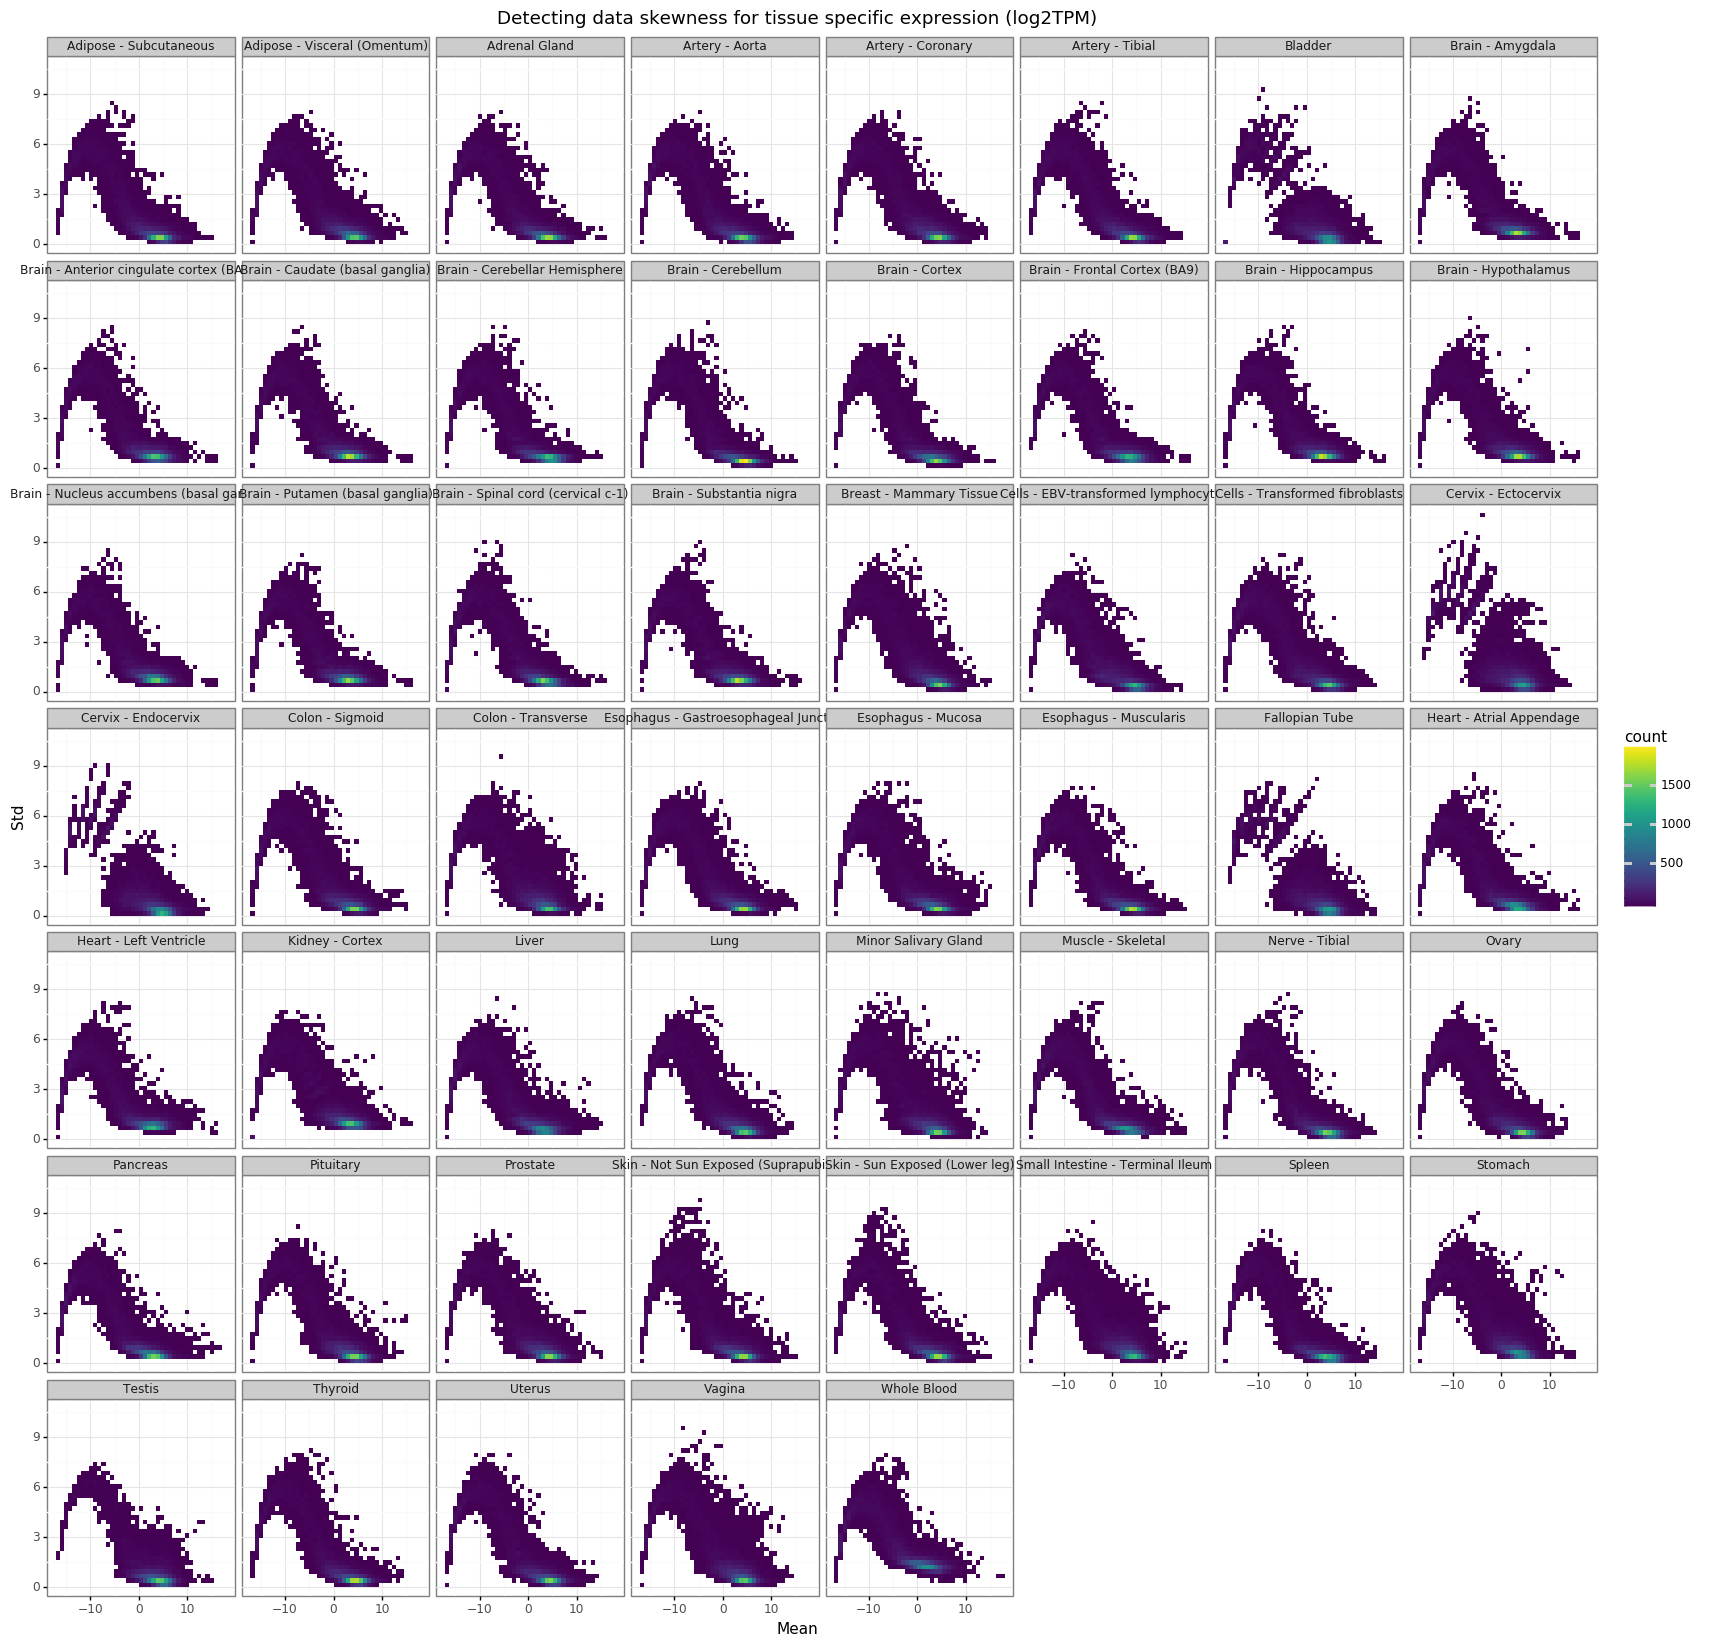

<ggplot: (-9223363255995433486)>

In [15]:
# f, ax = plt.subplots(1, 1)
# for t in all_tissues:
    
#     data = df_log_tpm[df_log_tpm['Tissue'] == t]
#     # true data
#     ax.scatter(data['Mean'], data['Std'], label = t)
#     plt.title("mean vs. std for all genes across tissues (computed using the log2 TPM)")
#     plt.xlabel("mean")
#     plt.ylabel("std")
# #     plt.yscale("log")

# ax.legend()
# fig = plt.gcf()
# fig.set_size_inches(20, 20)
# plt.show()

fig = ( 
            ggplot(df_log_tpm, aes('Mean', 'Std'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle("Detecting data skewness for tissue specific expression (log2TPM)")
            + theme(figure_size = (20, 20)) 
            + facet_wrap('~Tissue', ncol = 8))
fig

In [16]:
df_mean_expression.set_index('Tissue', inplace=True)

## 2. Define expressed genes

(array([5.1030e+03, 7.9700e+03, 6.8220e+03, 5.5440e+03, 4.6110e+03,
        4.3980e+03, 4.2580e+03, 4.0540e+03, 3.6710e+03, 3.6960e+03,
        3.7820e+03, 3.6100e+03, 3.5620e+03, 3.5760e+03, 3.5370e+03,
        3.6080e+03, 3.4560e+03, 3.5220e+03, 3.5570e+03, 3.5680e+03,
        3.5570e+03, 3.7740e+03, 3.6890e+03, 3.7630e+03, 3.9580e+03,
        4.0900e+03, 4.1090e+03, 4.4350e+03, 4.5260e+03, 4.7340e+03,
        5.0470e+03, 5.3690e+03, 5.6150e+03, 6.0380e+03, 6.3660e+03,
        6.8480e+03, 7.3670e+03, 8.2470e+03, 8.8310e+03, 9.7150e+03,
        1.0191e+04, 1.1066e+04, 1.2020e+04, 1.2965e+04, 1.3991e+04,
        1.4760e+04, 1.6120e+04, 1.6950e+04, 1.8707e+04, 2.0461e+04,
        2.2109e+04, 2.4588e+04, 2.7354e+04, 3.0751e+04, 3.4994e+04,
        3.9031e+04, 4.3743e+04, 4.6856e+04, 4.9430e+04, 5.0649e+04,
        5.0031e+04, 4.8122e+04, 4.4951e+04, 4.0528e+04, 3.5293e+04,
        2.9358e+04, 2.3790e+04, 1.8395e+04, 1.3951e+04, 1.0166e+04,
        7.3520e+03, 5.3580e+03, 4.0730e+03, 2.98

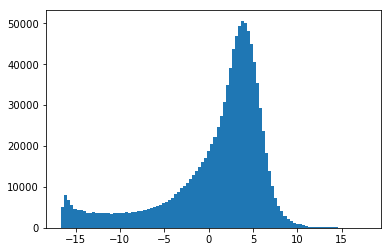

In [17]:
plt.hist(df_mean_expression.values.flatten(), bins=100)

In [18]:
expressed = df_mean_expression > 0

In [19]:
genes_intersection = expressed[expressed.index == 'Whole Blood'].values.flatten() & expressed[expressed.index == 'Muscle - Skeletal'].values.flatten()

In [20]:
genes_index = [i for i, j in enumerate(genes_intersection) if j == True]
genes_index[:10]

[2, 3, 5, 7, 8, 9, 11, 12, 16, 17]

In [21]:
"Number of genes expressed in Blood and Muscle: ", len(genes_index)

('Number of genes expressed in Blood and Muscle: ', 8885)

In [22]:
def to_log_ratio_with_epsilon(repobj, baseline_prediction, epsilon=1):
    
    x = np.zeros((repobj.X.shape[1],repobj.X.shape[0]))
    
    for i, sample in enumerate(repobj.samples_names):
        tissue = repobj.samples.loc[sample,'Tissue']
        
        a = np.array(repobj[sample].X,dtype=np.float32)
        a = a + epsilon
        
        b = np.array(baseline_prediction.loc[tissue,:],dtype=np.float32)
        
        # b already log2 transformed
        x[:,i] = np.log2(a) - b
    
    return x.transpose()

In [23]:
x_expression_ratios = to_log_ratio_with_epsilon(gtex, df_mean_expression, epsilon=1e-5)

In [24]:
expressed_genes_muscle_blood = gtex.genes.iloc[genes_index,:].index.tolist()

In [25]:
obj = prep.RepAnnData(X=x_expression_ratios, samples_obs = gtex.samples, genes_var=gtex.genes)

In [26]:
import os
# load invidivudals
path = os.path.join("..","..","data","processed","gtex","recount")
train, valid, test = [], [], []
states = ['train','valid','test']
dict_states_indiv = {'train':train,'valid':valid,'test':test}

for s in states:
    with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
        for l in f: dict_states_indiv[s].append(l.replace("\n",""))


(X_inputs, Y_targets) =  prep.rnaseq_train_valid_test(obj,dict_states_indiv,gtex.genes_names,onlyBlood=True)

compute all arrangements
Total pairs: 4403
compute all arrangements
Total pairs: 1630
compute all arrangements
Total pairs: 1558


In [27]:
(X_inputs_raw, Y_targets_raw) =  prep.rnaseq_train_valid_test(gtex_log_obj,dict_states_indiv,gtex.genes_names,onlyBlood=True)

compute all arrangements
Total pairs: 4403
compute all arrangements
Total pairs: 1630
compute all arrangements
Total pairs: 1558


In [28]:
# save inputs and targets
path = os.path.join("..","..","data","processed","gtex","input_data")
X_inputs_raw.save(os.path.join(path,'X_inputs_pc_onlyblood_log_tpm.h5'))
Y_targets_raw.save(os.path.join(path,'Y_targets_pc_onlyblood_log_tpm.h5'))

... storing 'Individual' as categorical
... storing 'Indiv_Seq_Assay' as categorical
... storing 'From_sample' as categorical
... storing 'Gender' as categorical
... storing 'From_tissue' as categorical
... storing 'From_parent_tissue' as categorical
... storing 'To_tissue' as categorical
... storing 'To_parent_tissue' as categorical
... storing 'To_sample' as categorical
... storing 'Type' as categorical


'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/data/processed/gtex/input_data/Y_targets_pc_onlyblood_log_tpm.h5'

## 3. Correlation between blood and other tissue

In [283]:
from scipy.stats import spearmanr
def plot_tissue_tissue_correlation(inputs, targets, gene_list, tissue_list=None, title = "", width=20, height=20, min_=-20, max_=20,  split_by_individuals = False):

    tissue = inputs.samples['To_tissue'].drop_duplicates().tolist() if tissue_list is None else tissue_list
    data = pd.DataFrame(columns = ['blood','other_tissue','to_tissue'])
    corr_coef_per_tissue = {}
    
    # pick 8 individuals which have all tissues if split by indiv is True
    if split_by_individuals:
        count_tissues = len(tissue)
        count_tissues_per_indiv= X_inputs.samples[X_inputs.samples['To_tissue'].isin(tissue)][['To_tissue','Individual']].drop_duplicates().groupby('Individual').count() 
        individuals_subset = count_tissues_per_indiv[count_tissues_per_indiv['To_tissue']>=count_tissues][:16].index.tolist()
        
        inputs = prep.RepAnnData.filter_samples(inputs, key = 'Individual', values=individuals_subset)
        targets= prep.RepAnnData.filter_samples(targets, key = 'Individual', values=individuals_subset)
    
    for t in tissue:
                
        blood_all = inputs[inputs.samples['To_tissue']==t]
        blood = blood_all.X[:, gene_list].flatten()
        
        other_tissue_all = targets[targets.samples['To_tissue']==t]
        other_tissue = other_tissue_all.X[:, gene_list].flatten()
        
        individuals = blood_all.obs['Individual'].tolist()
#         print(len(individuals), " should be the same as the ", blood_all.X.shape[0])
        individuals_repeat = np.array([individuals,]*len(gene_list)).transpose().flatten()
#         print("Individuals", len(individuals_repeat))
#         print("Other_tissue", len(other_tissue))
        
        data = data.append(pd.DataFrame(
                            data={
                                'blood':blood, 
                                'other_tissue':other_tissue,
                                'to_tissue':np.repeat(t, len(other_tissue)),
                                'individual': individuals_repeat}), ignore_index = True)
    
        # compute correlation
        corr_coef_per_tissue[t] = np.corrcoef(blood, other_tissue)[0][1]
#         a = np.nan_to_num(blood.reshape(-1, len(gene_list)))
#         b = np.nan_to_num(other_tissue.reshape(-1, len(gene_list)))
        
#         corr_coef_per_tissue[t] = np.median([spearmanr(a[:, x], b[:, x]) for x in range(len(gene_list))])

    
    if split_by_individuals == False:
        fig = ( 
            ggplot(data, aes('blood', 'other_tissue'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle(title)
            + theme(figure_size = (width, height)) 
            + xlim(min_, max_)
            + ylim(min_, max_)
            + facet_wrap('~to_tissue', ncol = 8))
    else:
        fig = ( 
            ggplot(data, aes('blood', 'other_tissue'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle(title)
            + theme(figure_size = (width, height)) 
            + xlim(min_, max_)
            + ylim(min_, max_)
            + facet_wrap('~individual', ncol = 8))

        
    return (fig, corr_coef_per_tissue)

#### 1. Random 8000 genes (all individuals, split by tissue)

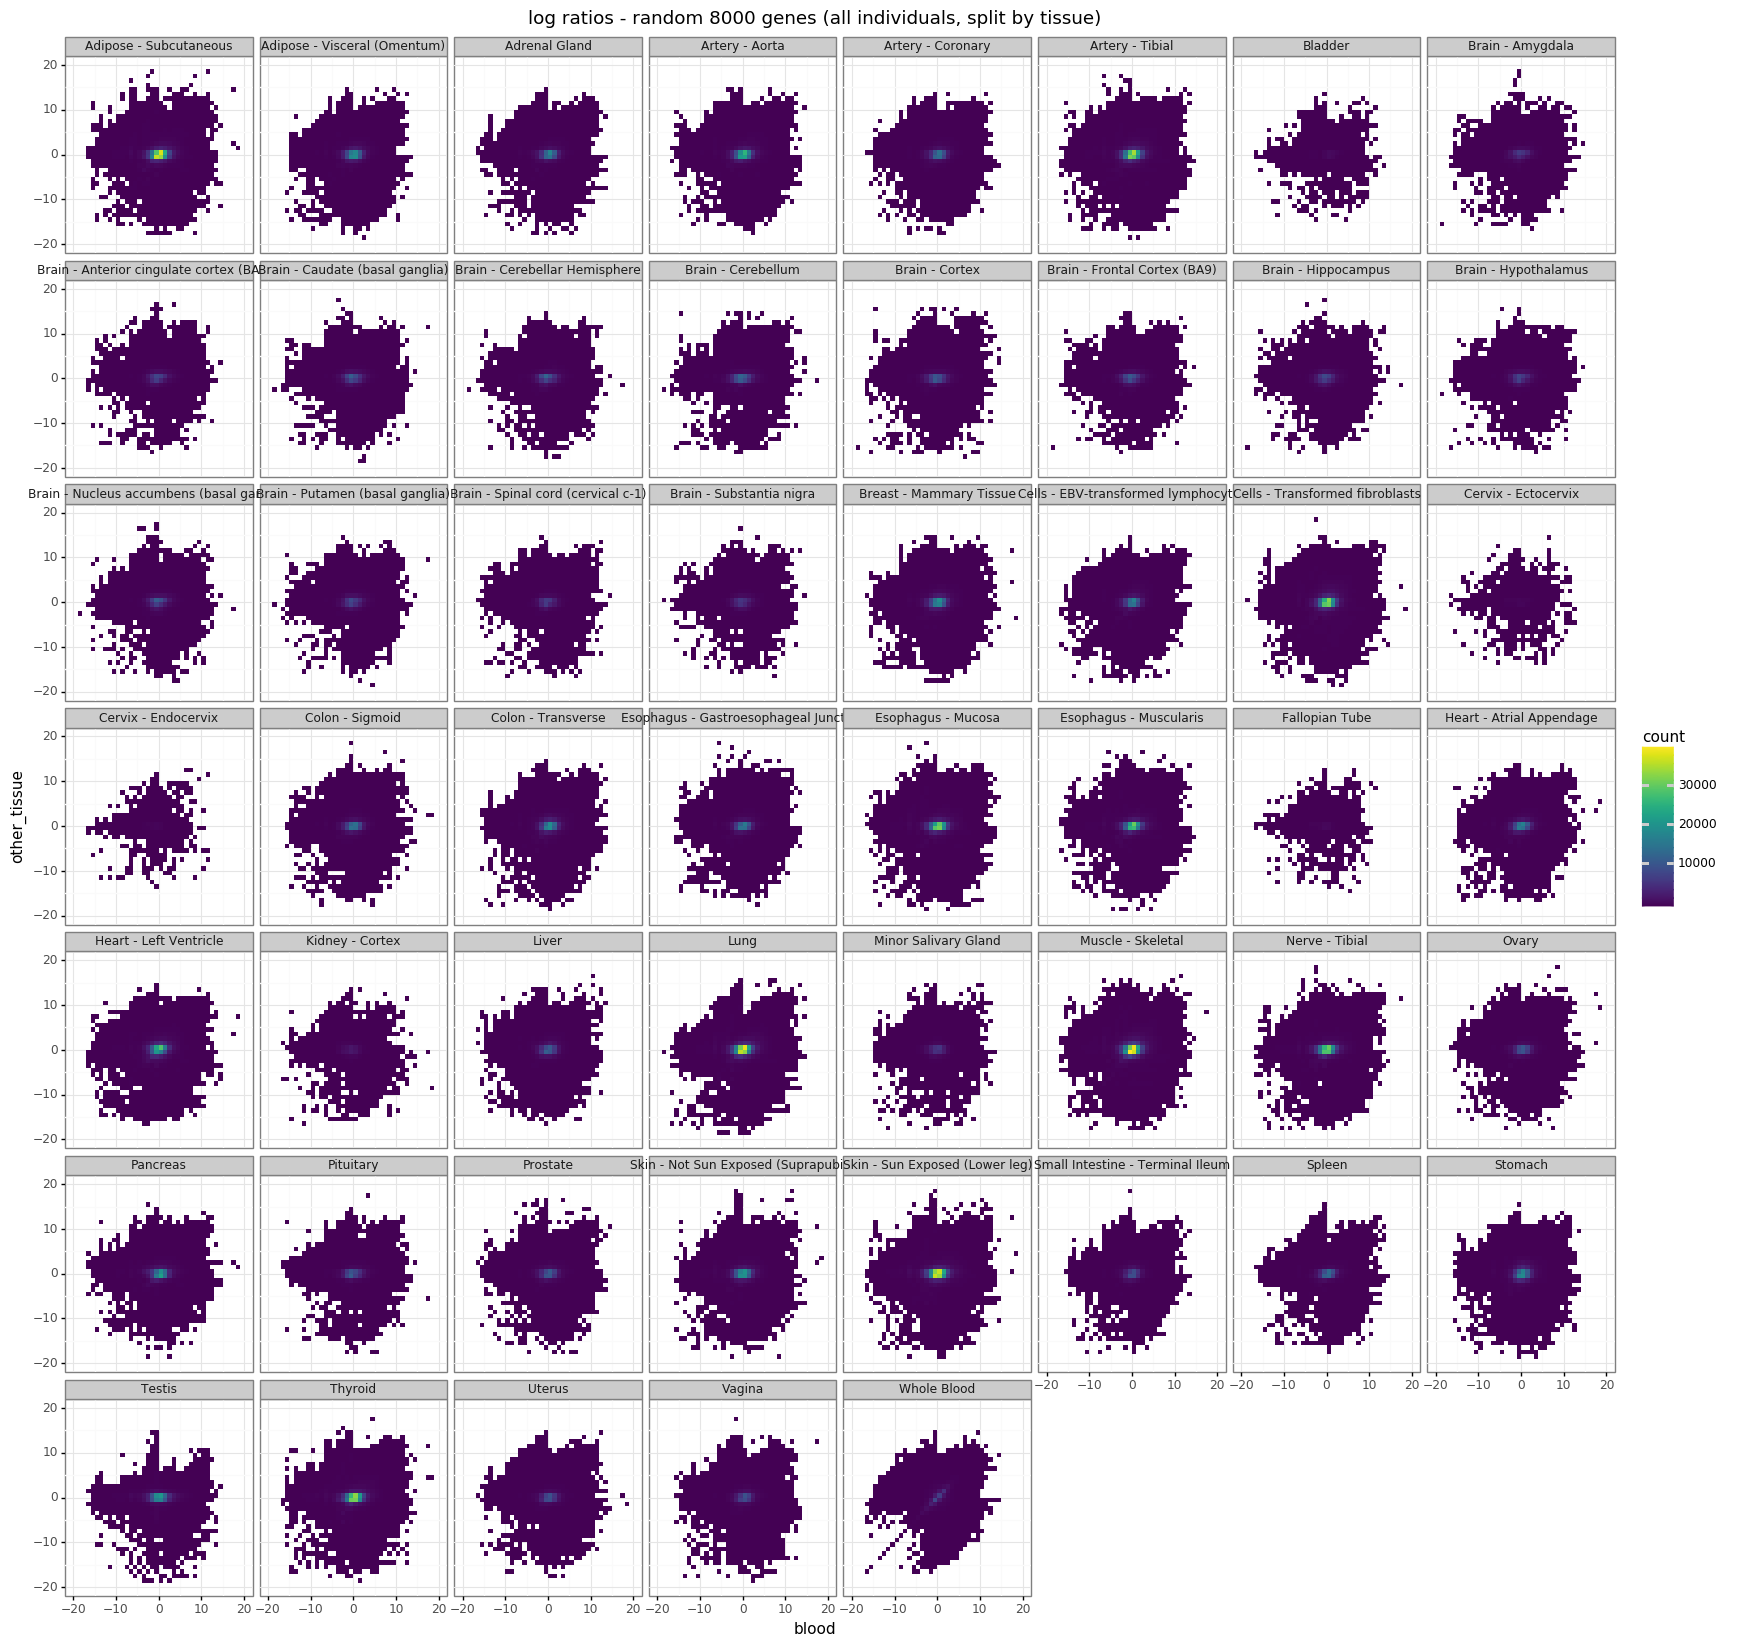

<ggplot: (8778775507176)>

In [23]:
import random
random_genes = random.sample(range(gtex.genes.shape[0]), 1000)
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs, Y_targets, random_genes, title = "log ratios - random 8000 genes (all individuals, split by tissue)")
fig_

In [24]:
# correlation between tissues
corr_coef

{'Adipose - Subcutaneous': 0.05304471763606288,
 'Pituitary': 0.03886319357680916,
 'Artery - Tibial': 0.06501011451650619,
 'Skin - Not Sun Exposed (Suprapubic)': 0.038349134954963136,
 'Muscle - Skeletal': 0.055857632712729303,
 'Brain - Cortex': 0.06834260975661921,
 'Skin - Sun Exposed (Lower leg)': 0.05209657310232728,
 'Nerve - Tibial': 0.05357695604855735,
 'Breast - Mammary Tissue': 0.033648870852357786,
 'Cells - Transformed fibroblasts': 0.01505651074280623,
 'Brain - Cerebellum': 0.07421488698335926,
 'Uterus': 0.018783711830562246,
 'Esophagus - Mucosa': 0.014424269576430887,
 'Esophagus - Gastroesophageal Junction': 0.045291369798466284,
 'Ovary': 0.03203126601450641,
 'Colon - Transverse': 0.026554623613229515,
 'Spleen': 0.03985668187409773,
 'Artery - Coronary': 0.0367204424507829,
 'Esophagus - Muscularis': 0.028815612724236463,
 'Heart - Atrial Appendage': 0.060392308737148764,
 'Stomach': 0.015980876873430746,
 'Adrenal Gland': 0.019738367894520947,
 'Heart - Left Ve

#### 2. Expressed genes in both blood and muscle (cutoff > 0 log2(TPM + 1e-5))

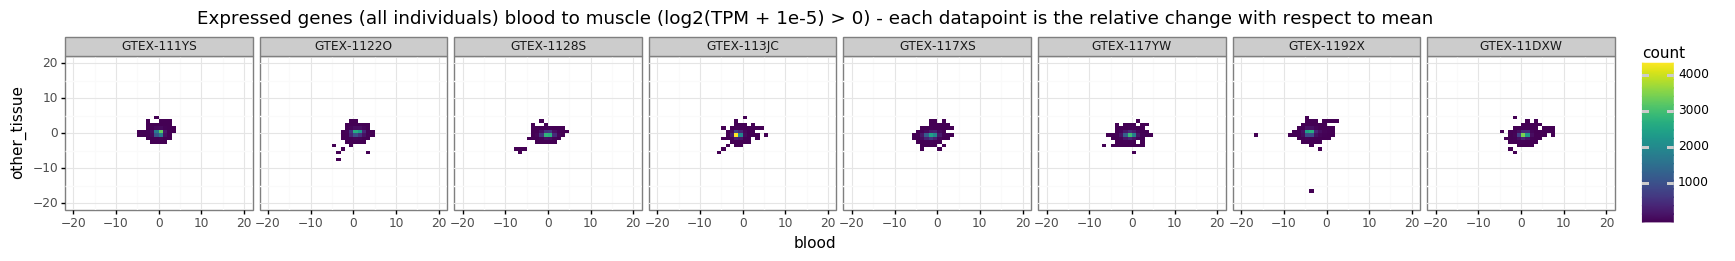

<ggplot: (8779646432211)>

In [26]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs,
                               Y_targets,
                               genes_index,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Expressed genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0) - each datapoint is the relative change with respect to mean",
                               split_by_individuals = True, width = 20, height = 2)
fig_

In [27]:
corr_coef

{'Muscle - Skeletal': -0.02344577928290091}

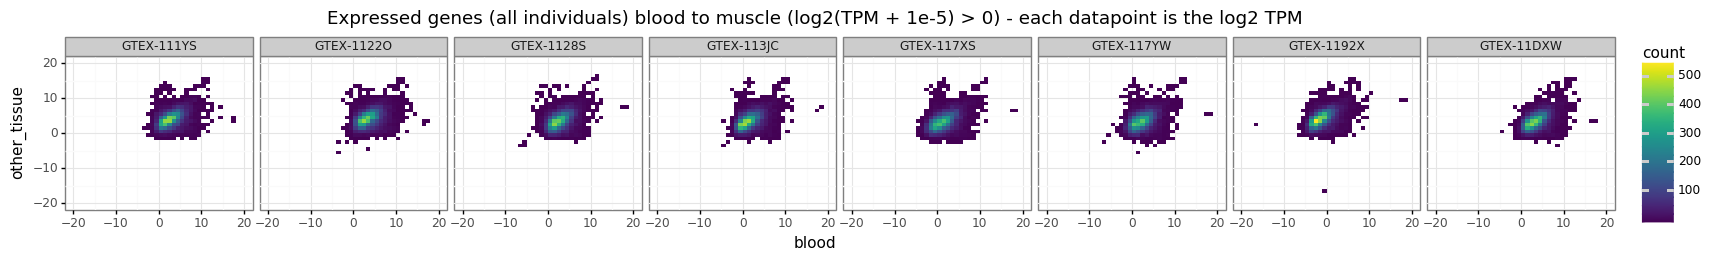

<ggplot: (-9223363257211451171)>

In [28]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs_raw,
                               Y_targets_raw,
                               genes_index,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Expressed genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0) - each datapoint is the log2 TPM",
                               split_by_individuals = True, width = 20, height = 2)
fig_

In [29]:
corr_coef

{'Muscle - Skeletal': 0.3354851263587059}

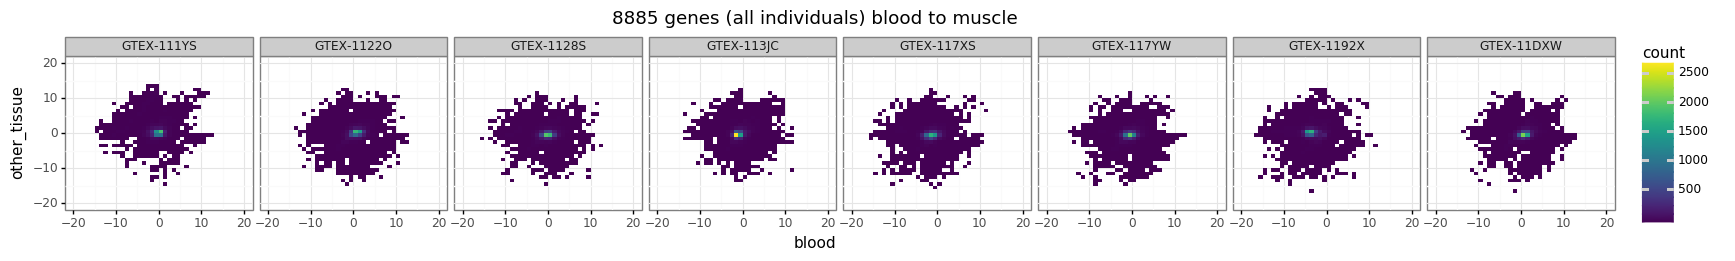

<ggplot: (-9223363257216623367)>

In [30]:
random_genes = random.sample(range(gtex.genes.shape[0]), len(genes_index))
(fig_, corr_coef) =  plot_tissue_tissue_correlation(X_inputs,
                               Y_targets,
                               random_genes,
                               tissue_list=['Muscle - Skeletal'], 
                               title = str(len(genes_index)) + " genes (all individuals) blood to muscle",
                               split_by_individuals = True, width = 20, height = 2)
fig_

In [31]:
corr_coef

{'Muscle - Skeletal': 0.016282898818147432}

#### 2.1 Log Ratios against raw TPM

In [32]:
log_ratios_blood = pd.concat([X_inputs[X_inputs.samples['From_tissue'] == 'Whole Blood'].to_df(), 
           pd.DataFrame(data={'Sample': X_inputs.samples[X_inputs.samples['From_tissue'] == 'Whole Blood']['From_sample']})
          ], axis=1, ignore_index=True).drop_duplicates().set_index(19932)
log_ratios_blood.columns = gtex.genes['gene_id'].tolist()

raw_blood = gtex[gtex.samples['Tissue'] == 'Whole Blood'].to_df()

# merge data
merged = pd.merge(log_ratios_blood, raw_blood, left_index=True, right_index=True)
data = pd.DataFrame(data={'log_ratios_blood': merged.iloc[:, :19932].values.flatten(),
                    'tmp_blood': merged.iloc[:, 19932:].values.flatten(),
                    'genes': np.repeat(log_ratios_blood.columns.tolist(), merged.shape[0])})

In [33]:
data.shape

(8550828, 3)

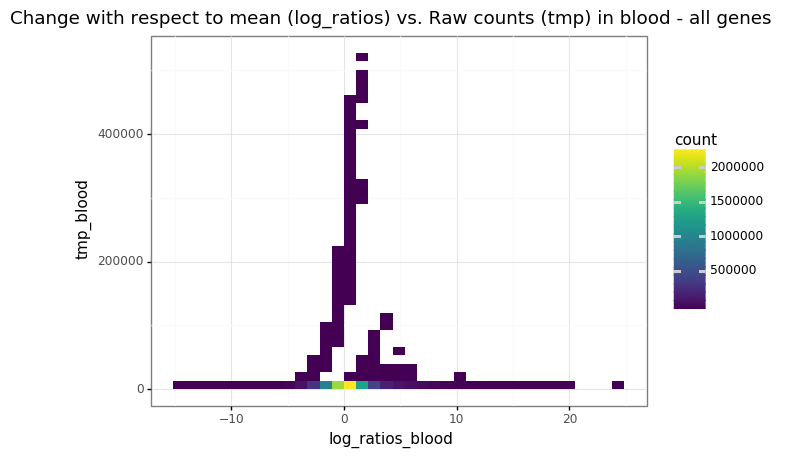

<ggplot: (-9223363257706722900)>

In [34]:
fig = ( 
            ggplot(data, aes('log_ratios_blood', 'tmp_blood'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle('Change with respect to mean (log_ratios) vs. Raw counts (tmp) in blood - all genes'))
fig

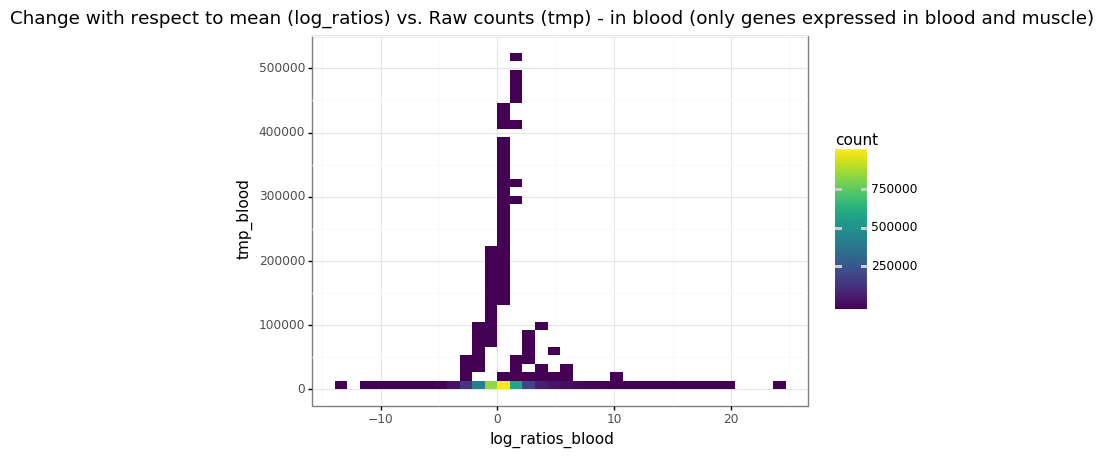

<ggplot: (-9223363257211460934)>

In [35]:
data_expressed_genes = data[data['genes'].isin(expressed_genes_muscle_blood)]
fig = ( 
            ggplot(data_expressed_genes, aes('log_ratios_blood', 'tmp_blood'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle('Change with respect to mean (log_ratios) vs. Raw counts (tmp) - in blood (only genes expressed in blood and muscle)'))
fig

In [36]:
len(expressed_genes_muscle_blood)

8885

## 4. Variable genes in both blood and muscle

In [37]:
log_gtex = np.log2(np.array(gtex.X)+ 1e-5)
gtex_log_obj = prep.RepAnnData(X=log_gtex, samples_obs = gtex.samples, genes_var = gtex.genes) 
all_tissues = gtex.samples['Tissue'].drop_duplicates().tolist()

genes = gtex.genes['gene_id'].tolist()
df_std_expression = pd.DataFrame(columns=['Tissue']+genes)


# std deviation expression
for t in all_tissues:
    tmp = np.array(gtex_log_obj[gtex_log_obj.samples['Tissue'] == t].X)
    avg_per_gene = np.std(tmp, axis = 0)
    
    dict = {}
    dict['Tissue'] = t
    for i, g in enumerate(avg_per_gene): dict[genes[i]] = g
    df_std_expression = df_std_expression.append(dict, ignore_index = True)

In [38]:
df_std_expression.set_index('Tissue', inplace=True)

(array([2.29400e+03, 1.55160e+04, 8.42830e+04, 1.23272e+05, 1.17385e+05,
        1.08981e+05, 9.46110e+04, 7.20420e+04, 5.44950e+04, 4.18070e+04,
        3.35000e+04, 2.58070e+04, 2.00900e+04, 1.56960e+04, 1.25560e+04,
        1.05410e+04, 9.05300e+03, 7.94100e+03, 7.06700e+03, 6.45700e+03,
        6.18300e+03, 5.63300e+03, 5.44800e+03, 5.13800e+03, 4.96300e+03,
        4.77400e+03, 4.56400e+03, 4.57600e+03, 4.40900e+03, 4.30100e+03,
        4.16900e+03, 4.06400e+03, 4.02900e+03, 4.06700e+03, 4.08000e+03,
        4.09800e+03, 4.12600e+03, 4.30100e+03, 4.28600e+03, 4.45000e+03,
        4.62500e+03, 4.70700e+03, 4.99100e+03, 5.11800e+03, 5.29700e+03,
        5.54200e+03, 5.72000e+03, 5.89000e+03, 5.90900e+03, 5.76600e+03,
        5.76600e+03, 5.46800e+03, 5.28800e+03, 4.82300e+03, 4.35900e+03,
        3.96100e+03, 3.49600e+03, 2.94700e+03, 2.56100e+03, 2.00300e+03,
        1.61500e+03, 1.24700e+03, 9.84000e+02, 7.67000e+02, 5.61000e+02,
        4.47000e+02, 3.16000e+02, 2.63000e+02, 1.55

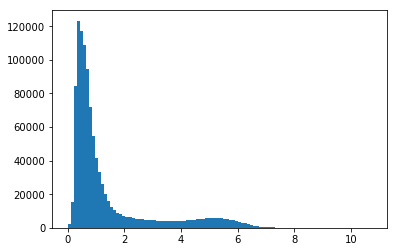

In [39]:
plt.hist(df_std_expression.values.flatten(), bins=100)

In [40]:
variable_genes = df_std_expression > 1

In [41]:
genes_intersection = variable_genes[variable_genes.index == 'Whole Blood'].values.flatten() & variable_genes[variable_genes.index == 'Muscle - Skeletal'].values.flatten()

In [42]:
genes_index_std = [i for i, j in enumerate(genes_intersection) if j == True]
"Variable genes in blood and muscle: ", len(genes_index_std)

('Variable genes in blood and muscle: ', 7641)

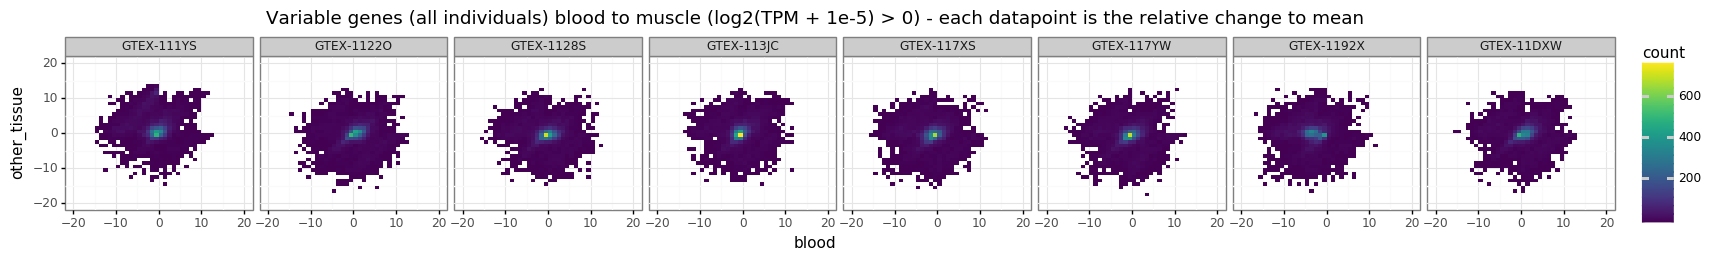

<ggplot: (-9223363257707683931)>

In [43]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs,
                               Y_targets,
                               genes_index_std,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Variable genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0) - each datapoint is the relative change to mean",
                               split_by_individuals = True, width = 20, height = 2)
fig_

In [44]:
corr_coef

{'Muscle - Skeletal': 0.02341712062472012}

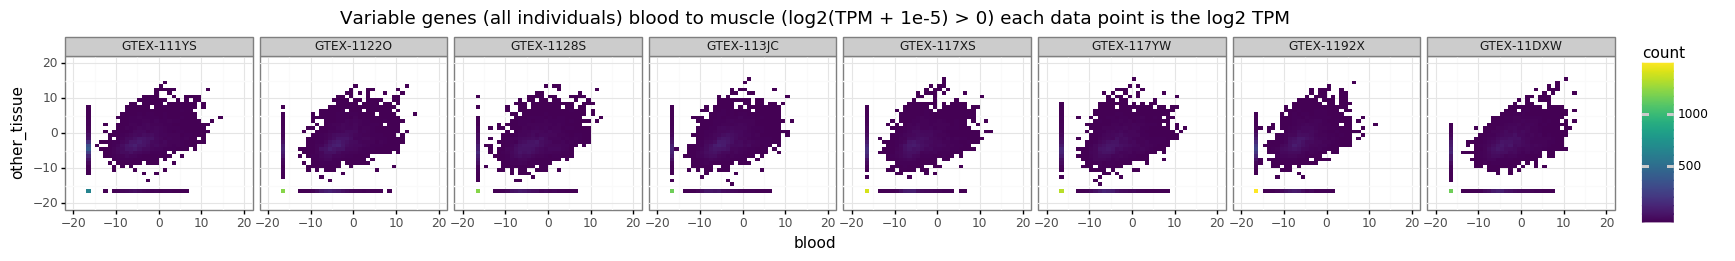

<ggplot: (-9223363257211457357)>

In [45]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs_raw,
                               Y_targets_raw,
                               genes_index_std,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Variable genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0) each data point is the log2 TPM",
                               split_by_individuals = True, width = 20, height = 2)
fig_

In [46]:
corr_coef

{'Muscle - Skeletal': 0.5389010389132227}

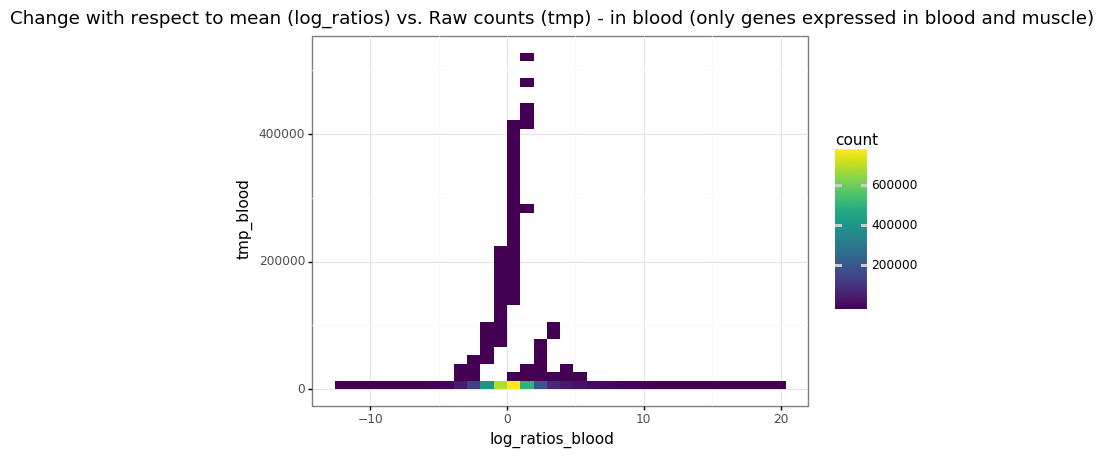

<ggplot: (-9223363257443972534)>

In [47]:
variable_genes_muscle_blood = gtex.genes.iloc[genes_index_std,:].index.tolist()
data_expressed_genes = data[data['genes'].isin(variable_genes_muscle_blood)]
fig = ( 
            ggplot(data_expressed_genes, aes('log_ratios_blood', 'tmp_blood'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle('Change with respect to mean (log_ratios) vs. Raw counts (tmp) - in blood (only genes expressed in blood and muscle)'))
fig

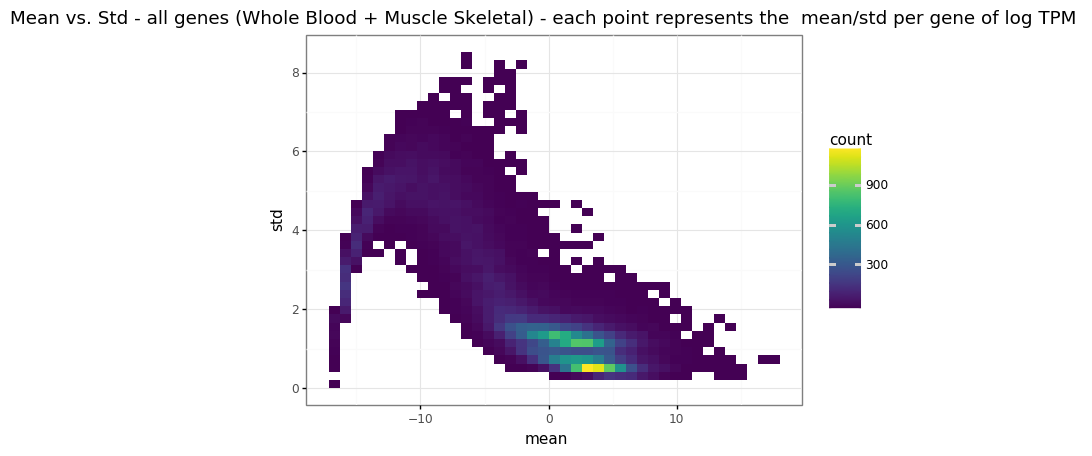

<ggplot: (8779417473130)>

In [174]:
df = pd.DataFrame(data= {"mean": df_mean_expression[df_mean_expression.index.isin(['Whole Blood','Muscle - Skeletal'])].values.flatten(),
                        "std": df_std_expression[df_std_expression.index.isin(['Whole Blood','Muscle - Skeletal'])].values.flatten()})

fig = ( 
            ggplot(df, aes('mean', 'std'))
            + geom_bin2d(bins = 40)
            + theme_bw()
            + ggtitle('Mean vs. Std - all genes (Whole Blood + Muscle Skeletal) - each point represents the  mean/std per gene of log TPM '))
fig

In [213]:
to_keep_both_index = list(set(np.where(np.sum(np.array(gtex_log_obj[gtex_log_obj.samples['Tissue'] == 'Whole Blood'].X),axis=0) > 0)[0]) & set(np.where(np.sum(np.array(gtex_log_obj[gtex_log_obj.samples['Tissue'] == 'Muscle - Skeletal'].X),axis=0) > 0)[0]))
len(to_keep_both_index)

8885

In [214]:
variable_genes = df_std_expression > 2
expressed_genes = df_mean_expression > 5 

# variable genes
genes_intersection = variable_genes[variable_genes.index == 'Whole Blood'].values.flatten() & variable_genes[variable_genes.index == 'Muscle - Skeletal'].values.flatten()
genes_index_std = [i for i, j in enumerate(genes_intersection) if j == True]


genes_intersection = expressed_genes[expressed_genes.index == 'Whole Blood'].values.flatten() & expressed_genes[expressed_genes.index == 'Muscle - Skeletal'].values.flatten()
genes_index_mean = [i for i, j in enumerate(genes_intersection) if j == True]

variable_genes_muscle_blood = gtex.genes.iloc[genes_index_std,:].index.tolist()
expressed_genes_muscle_blood = gtex.genes.iloc[genes_index_mean,:].index.tolist()
to_keep_both = gtex.genes.iloc[to_keep_both_index,:].index.tolist()

In [220]:
variable_and_expressed_genes_muscle_blood = list(set(variable_genes_muscle_blood) | set(expressed_genes_muscle_blood))
variable_and_expressed_genes_muscle_blood_index = list(set(genes_index) | set(genes_index_std)) 
print("Genes which are variable and are expressed in both blood and muscle: ", len(variable_and_expressed_genes_muscle_blood_index))

Genes which are variable and are expressed in both blood and muscle:  13105


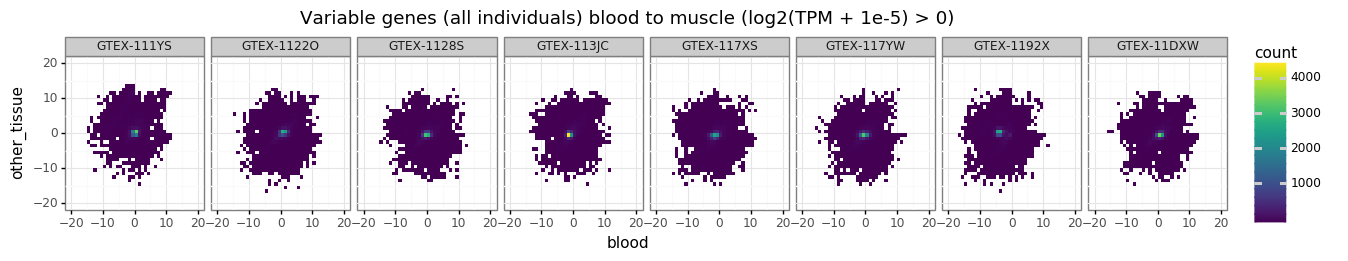

<ggplot: (-9223363257706778108)>

In [221]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs,
                               Y_targets,
                               variable_and_expressed_genes_muscle_blood_index,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Variable genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0)",
                               split_by_individuals = True, width = 15, height = 2)
fig_

In [222]:
corr_coef

{'Muscle - Skeletal': 0.016391570741078484}

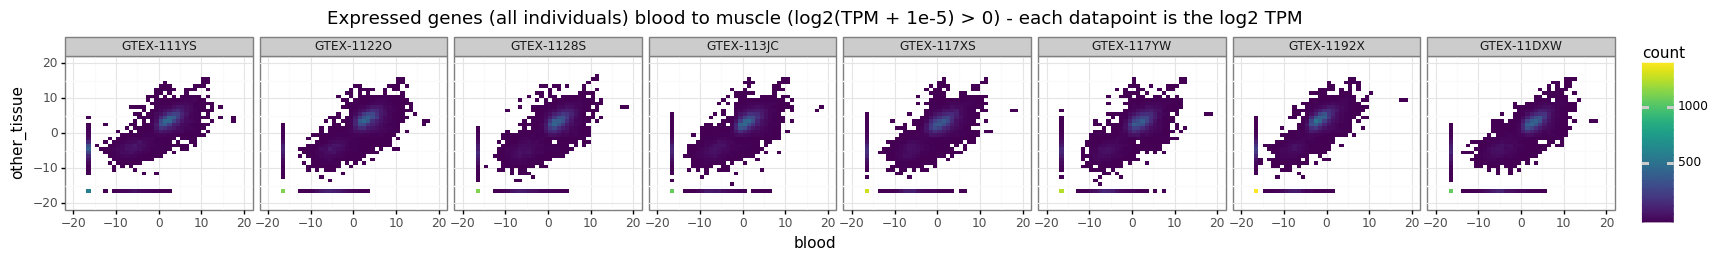

<ggplot: (8779605303609)>

In [223]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs_raw,
                               Y_targets_raw,
                               variable_and_expressed_genes_muscle_blood_index,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Expressed genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0) - each datapoint is the log2 TPM",
                               split_by_individuals = True, width = 20, height = 2)
fig_

In [180]:
corr_coef

{'Muscle - Skeletal': 0.7958677478064076}

In [181]:
import os
from rep import preprocessing_new as prep
out = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data","genes_subset","candidate_genes.txt")
prep.save_list(out, variable_and_expressed_genes_muscle_blood)

## 5. Keep only genes for which the correlation of the change relative to mean, between blood and muscle is > 0.6

In [247]:
from scipy.stats import spearmanr

a = np.array(X_inputs[X_inputs.samples['To_tissue'] == 'Muscle - Skeletal'].X)
b = np.array(Y_targets[Y_targets.samples['To_tissue'] == 'Muscle - Skeletal'].X)
corr_input_output = [spearmanr(a[:, x], b[:, x])[0] for x in range(a.shape[1])]

from scipy.stats import spearmanr

a_raw = np.array(X_inputs_raw[X_inputs_raw.samples['To_tissue'] == 'Muscle - Skeletal'].X)
b_raw  = np.array(Y_targets_raw[Y_targets_raw.samples['To_tissue'] == 'Muscle - Skeletal'].X)
corr_input_output_raw = [spearmanr(a_raw[:, x], b_raw[:, x])[0] for x in range(a_raw.shape[1])]

(array([1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 6.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 8.000e+00, 9.000e+00, 2.200e+01, 1.800e+01,
        1.900e+01, 2.300e+01, 2.000e+01, 2.900e+01, 3.000e+01, 3.100e+01,
        4.500e+01, 6.600e+01, 6.000e+01, 9.800e+01, 9.500e+01, 1.340e+02,
        1.500e+02, 2.010e+02, 2.210e+02, 2.900e+02, 3.500e+02, 4.450e+02,
        5.110e+02, 5.770e+02, 6.720e+02, 7.740e+02, 8.630e+02, 9.210e+02,
        1.009e+03, 1.058e+03, 1.036e+03, 1.010e+03, 9.780e+02, 8.820e+02,
        7.980e+02, 7.770e+02, 7.480e+02, 6.330e+02, 6.120e+02, 4.960e+02,
        4.710e+02, 4.070e+02, 3.610e+02, 3.270e+02, 2.690e+02, 2.030e+02,
        1.590e+02, 1.400e+02, 1.400e+02, 1.090e+02, 1.060e+02, 9.100e+01,
        7.400e+01, 6.200e+01, 4.600e+01, 3.600e+01, 3.300e+01, 2.800e+01,
        2.500e+01, 1.900e+01, 8.000e+00, 1.100e+01, 1.100e+01, 8.000e+00,
        4.000e+00, 7.000e+00, 6.000e+0

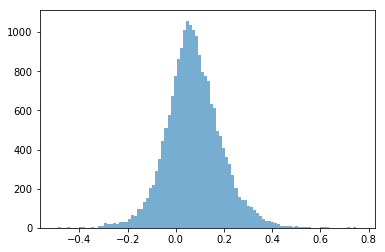

In [278]:
plt.hist(corr_input_output, bins=100, alpha=0.6)

In [271]:
index_genes_to_keep = np.where(np.array(corr_input_output) > 0.15)[0]

In [272]:
genes_to_keep = gtex.genes.iloc[index_genes_to_keep,:].index.tolist()

In [273]:
len(genes_to_keep)

4557

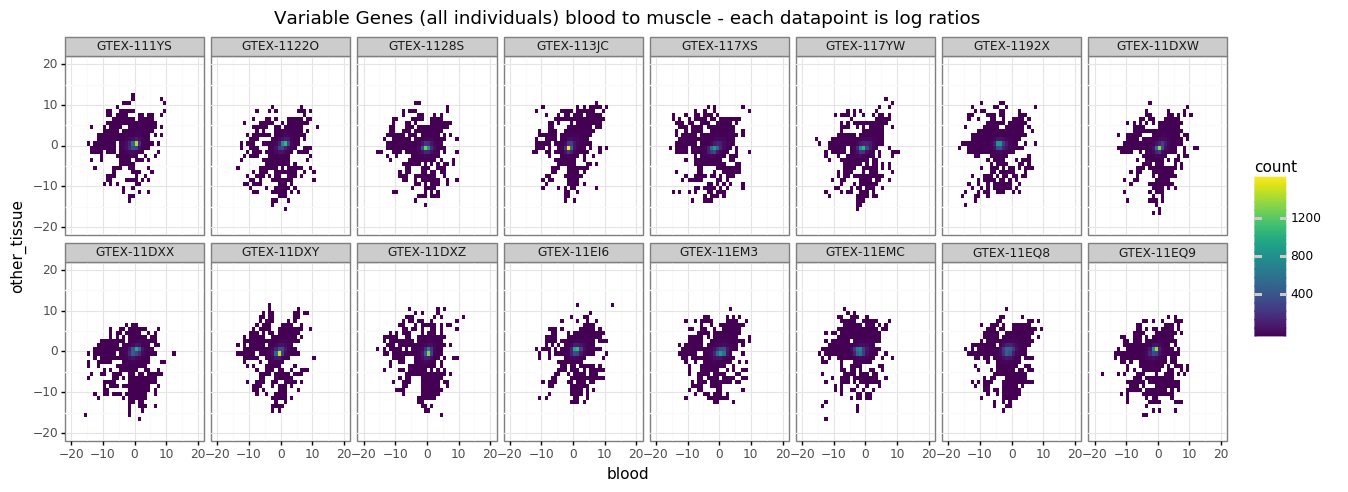

<ggplot: (-9223363257686409100)>

In [290]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs,
                               Y_targets,
                               index_genes_to_keep,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Variable Genes (all individuals) blood to muscle - each datapoint is log ratios",
                               split_by_individuals = True, width = 15, height = 5)
fig_

In [291]:
corr_coef

{'Muscle - Skeletal': 0.11043670897749722}

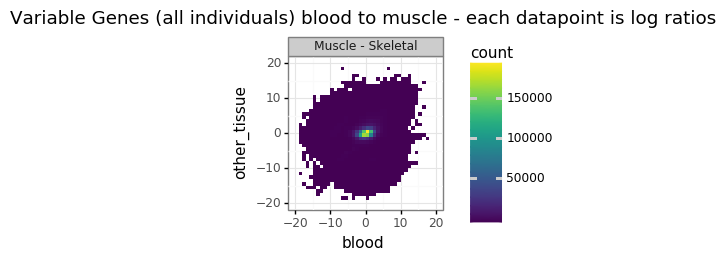

<ggplot: (8779646460238)>

In [288]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs,
                               Y_targets,
                               index_genes_to_keep,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Variable Genes (all individuals) blood to muscle - each datapoint is log ratios",
                               split_by_individuals = False, width = 2, height = 2)
fig_

In [289]:
corr_coef

{'Muscle - Skeletal': 0.1860392045948237}

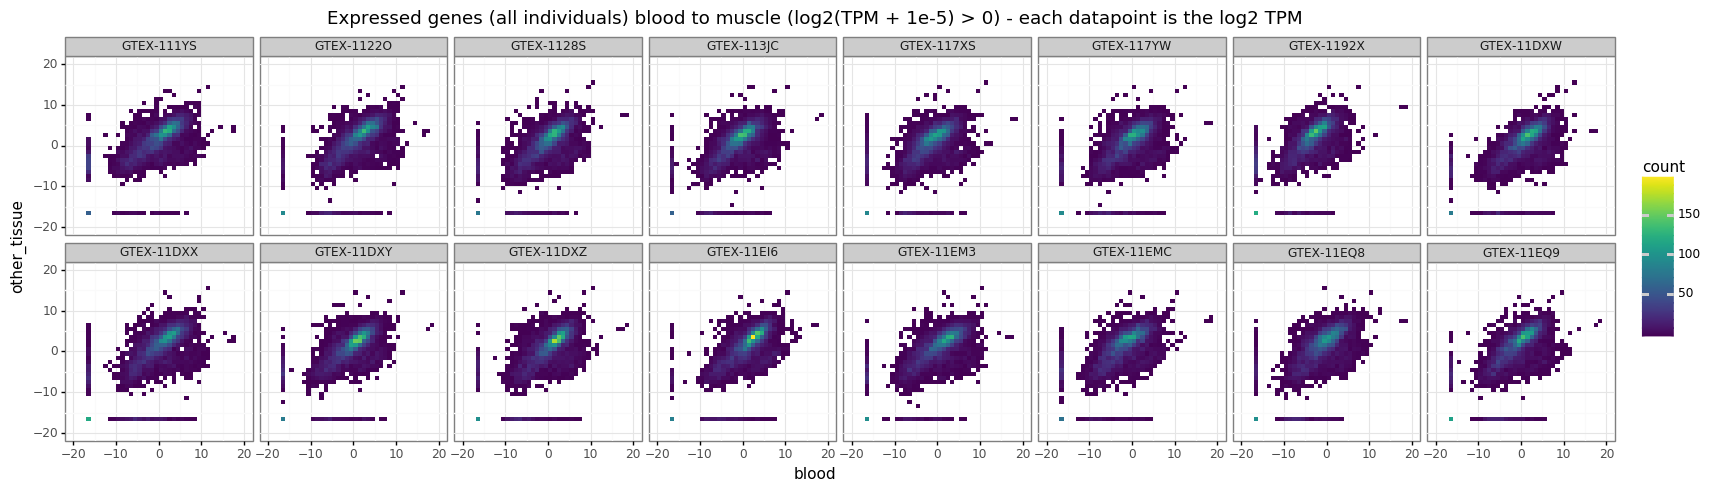

<ggplot: (8779407239253)>

In [292]:
(fig_, corr_coef) = plot_tissue_tissue_correlation(X_inputs_raw,
                               Y_targets_raw,
                               index_genes_to_keep,
                               tissue_list=['Muscle - Skeletal'], 
                               title = "Expressed genes (all individuals) blood to muscle (log2(TPM + 1e-5) > 0) - each datapoint is the log2 TPM",
                               split_by_individuals = True, width = 20, height = 5)
fig_

In [293]:
corr_coef

{'Muscle - Skeletal': 0.6266129726113184}

In [295]:
out = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data","genes_subset","correlating_genes_blood_muscle_015.txt")
prep.save_list(out,genes_to_keep)

## Checking if the samples pairing when correct. We do notice that we also paired within same tissue, same patient which had different Sequencing runs

#### Pairs in blood for patient GTEX-PX3G

In [114]:
X_inputs.samples[(X_inputs.samples['To_tissue'] == 'Whole Blood') & (X_inputs.samples['Individual'] == 'GTEX-PX3G')]

,Index,Individual,Indiv_Seq_Assay,From_sample,Gender,From_tissue,From_parent_tissue,To_tissue,To_parent_tissue,To_sample,Type
SRR598300_SRR659061,SRR598300_SRR659061,GTEX-PX3G,WGS,SRR598300,female,Whole Blood,Blood,Whole Blood,Blood,SRR659061,train
SRR598300_SRR1389133,SRR598300_SRR1389133,GTEX-PX3G,WGS,SRR598300,female,Whole Blood,Blood,Whole Blood,Blood,SRR1389133,train
SRR659061_SRR598300,SRR659061_SRR598300,GTEX-PX3G,WGS,SRR659061,female,Whole Blood,Blood,Whole Blood,Blood,SRR598300,train
SRR659061_SRR1389133,SRR659061_SRR1389133,GTEX-PX3G,WGS,SRR659061,female,Whole Blood,Blood,Whole Blood,Blood,SRR1389133,train
SRR1389133_SRR598300,SRR1389133_SRR598300,GTEX-PX3G,WGS,SRR1389133,female,Whole Blood,Blood,Whole Blood,Blood,SRR598300,train
SRR1389133_SRR659061,SRR1389133_SRR659061,GTEX-PX3G,WGS,SRR1389133,female,Whole Blood,Blood,Whole Blood,Blood,SRR659061,train


#### In original gtex metadata

In [116]:
gtex.samples[(gtex.samples['Individual'] == 'GTEX-PX3G') & (gtex.samples['Taissue'] == 'Whole Blood')]

,project,sample,experiment,mapped_read_count,avg_read_length,Sample_Name,smatsscr,Parent_Tissue,Tissue,Individual,Gender,Assay_Type_s,Instrument_s,Indiv_Seq_Assay
SRR598300,SRP012682,SRS333564,SRX198179,81524807,152,GTEX-PX3G-0006-SM-2I3E4,,Blood,Whole Blood,GTEX-PX3G,female,RNA-Seq,Illumina HiSeq 2000,WGS
SRR1389133,SRP012682,SRS636259,SRX595040,99074866,152,GTEX-PX3G-0006-SM-5SI7E,,Blood,Whole Blood,GTEX-PX3G,female,RNA-Seq,Illumina HiSeq 2000,WGS
SRR659061,SRP012682,SRS389642,SRX222470,74452564,152,GTEX-PX3G-0006-SM-33HBQ,,Blood,Whole Blood,GTEX-PX3G,female,RNA-Seq,Illumina HiSeq 2000,WGS
